<a href="https://colab.research.google.com/github/bernick27/classification_social_media_comments/blob/main/training_s2s_social_media_comments_vCPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Entrenamiento del modelo S2S con atención para clasificar comentarios de redes sociales sobre eventos educativos**

## 1. Lectura y visualización del corpus

**Corpus: DESIGNACIONES Y CESES**

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import pickle

with open('/gdrive/My Drive/PEPS/TXT_DICT_ETIQUETADOS/corpus_17-06-2021', 'rb') as d:
    txt_dict = pickle.load(d)

query_data, slot_data, type_data, state_data = txt_dict['sentences'], txt_dict['slot_sequences'], txt_dict['types'], txt_dict['states']

In [ ]:
import pandas as pd

# Show some examples in table
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({'query': query_data, 'slot': slot_data, 'type_': type_data, 'state': state_data})

df_small = pd.DataFrame(columns=['query', 'slot', 'type_', 'state'])
j = 0
for i in df.type_.unique():
  df_small.loc[j] = df[df.type_==i].iloc[0]
  j = j+1
  
df_small

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,query,slot,type_,state
0,Nombrar Ministro de Estado en el Despacho del Ambiente al señor Manuel Gerardo Pedro Pulgar-Vidal Otálora,<o> B-<cargo_pep> I-<cargo_pep> I-<cargo_pep> <o> <o> B-<entidad_pep> I-<entidad_pep> I-<entidad_pep> <o> <o> B-<nombre_pep> I-<nombre_pep> I-<nombre_pep> B-<apellido_pep> I-<apellido_pep>,designacion,completo
1,Dar por concluida la encargatura del señor Mario César Augusto Condado Vega efectuada mediante Resolución Directoral N 216-2016-PCM/OGA de fecha 21 de noviembre de 2016 dándosele las gracias por los servicios prestados,<o> <o> <o> <o> <o> <o> <o> B-<nombre_pep> I-<nombre_pep> I-<nombre_pep> B-<apellido_pep> I-<apellido_pep> <o> <o> <o> <o> <o> <o> <o> <o> B-<fecha> I-<fecha> I-<fecha> I-<fecha> I-<fecha> <o> <o> <o> <o> <o> <o> <o>,cese,incompleto
2,Encargar a la Sub Gerencia de Gestión Humana de la Institución que notifique al señor José Carlos Purizaca Vega la presente resolución así como la carta que detalle las características que comprende la designación realizada,<o> <o> <o> <o> <o> <o> <o> <o> <o> <o> <o> <o> <o> <o> <o> B-<nombre> I-<nombre> B-<apellido> I-<apellido> <o> <o> <o> <o> <o> <o> <o> <o> <o> <o> <o> <o> <o> <o> <o> <o>,otro,completo


In [ ]:
query_data_temp = query_data
slot_data_temp = slot_data
for i in range(len(query_data_temp)):
  query_data[i] = 'BOS ' + query_data_temp[i] + ' EOS'
  slot_data_temp[i] = '<o> ' + slot_data_temp[i] + ' <o>'

In [ ]:
import re

# Obtención de las frecuencias
vocab_word = {}
for query in query_data:
  for word in query.split():
    key = word.lower()
    vocab_word[key] = vocab_word.get(key, 0) + 1

vocab_word = {k: v for k, v in sorted(vocab_word.items(), key=lambda item: item[1])}

# Selección de las N palabras con mayor frecuencia
cnt1, cnt2, cnt3 = 0, 0, 0
for word, freq in vocab_word.items():
  if freq == 1:
    cnt1 += 1
  elif freq == 2:
    cnt2 += 1
  elif freq == 3:
    cnt3 += 1
print('Número de palabras con frecuencia de 1: ', cnt1)
print('Número de palabras con frecuencia de 2: ', cnt2)
print('Número de palabras con frecuencia de 3: ', cnt3)
N = int(0.02 * cnt1)
words2replace = list(vocab_word.keys())[:N]
for word in words2replace:
  if re.match(r'.+[ar|er|ir]', word):
    words2replace.remove(word)

# Reemplazo en todas las oraciones
pattern = r'\b' + r'\b|\b'.join(words2replace) + r'\b'
for i, query in enumerate(query_data):
  query_data[i] = re.sub(pattern, 'unk', query.lower())

Número de palabras con frecuencia de 1:  2525
Número de palabras con frecuencia de 2:  1061
Número de palabras con frecuencia de 3:  450


## 2. Tokenización

In [ ]:
from tensorflow.python.keras.preprocessing.text import Tokenizer

# Tokenización
word_tokenizer = Tokenizer(filters='\n', oov_token='unk')
word_tokenizer.fit_on_texts(query_data)

w2i_dict = {}
i2w_dict = {}
for i in range(len(word_tokenizer.word_index)):
  w2i_dict[word_tokenizer.index_word[i + 2]] = i + 1
  i2w_dict[i + 1] = word_tokenizer.index_word[i + 2]

word_tokenizer.word_index = w2i_dict
word_tokenizer.index_word = i2w_dict
word_index = word_tokenizer.word_index

slot_tokenizer = Tokenizer(filters='\n') #, oov_token='<o>')
slot_tokenizer.fit_on_texts(slot_data)
slot_index = slot_tokenizer.word_index

type_tokenizer = Tokenizer(filters='\n')
type_tokenizer.fit_on_texts(type_data)
type_index = type_tokenizer.word_index

state_tokenizer = Tokenizer(filters='\n')
state_tokenizer.fit_on_texts(state_data)
state_index = state_tokenizer.word_index

'''# Modificación de la tokenización para adecuar al modelo
w2i_dict = {}
i2w_dict = {}
s2i_dict = {}
i2s_dict = {}
t2i_dict = {}
i2t_dict = {}
st2i_dict = {}
i2st_dict = {}

for i in range(len(word_tokenizer.word_index)):
  w2i_dict[word_tokenizer.index_word[i+2]] = i
  i2w_dict[i] = word_tokenizer.index_word[i+2]

word_tokenizer.word_index = w2i_dict
word_tokenizer.index_word = i2w_dict
word_index = word_tokenizer.word_index

for i in range(len(slot_tokenizer.word_index)):
  s2i_dict[slot_tokenizer.index_word[i+2]] = i
  i2s_dict[i] = slot_tokenizer.index_word[i+2]

slot_tokenizer.word_index = s2i_dict
slot_tokenizer.index_word = i2s_dict
slot_index = slot_tokenizer.word_index

for i in range(len(type_tokenizer.word_index)):
  t2i_dict[type_tokenizer.index_word[i+1]] = i
  i2t_dict[i] = type_tokenizer.index_word[i+1]

type_tokenizer.word_index = t2i_dict
type_tokenizer.index_word = i2t_dict
type_index = type_tokenizer.word_index

for i in range(len(state_tokenizer.word_index)):
  st2i_dict[state_tokenizer.index_word[i+1]] = i
  i2st_dict[i] = state_tokenizer.index_word[i+1]

state_tokenizer.word_index = st2i_dict
state_tokenizer.index_word = i2st_dict
state_index = state_tokenizer.word_index'''

num_words = len(word_index)
num_slots = len(slot_index)
num_types = len(type_index)
num_states = len(state_index)

print('Tokenización completada!')
print('Words: {:4d}'.format(num_words))
print('Slots: {:4d}'.format(num_slots))
print('Intents1: {:4d}'.format(num_types))
print('Intents2: {:4d}'.format(num_states))

Tokenización completada!
Words: 6006
Slots:   23
Intents1:    3
Intents2:    2


In [ ]:
state_tokenizer.index_word

{1: 'completo', 2: 'incompleto'}

In [ ]:
type_index

{'cese': 3, 'designacion': 2, 'otro': 1}

In [ ]:
state_index

{'completo': 1, 'incompleto': 2}

## 3. Preparación de la data (generators)

In [ ]:
query_data_DC = []; slot_data_DC = []; type_data_DC = []; state_data_DC = []
query_data_CC = []; slot_data_CC = []; type_data_CC = []; state_data_CC = []
query_data_OC = []; slot_data_OC = []; type_data_OC = []; state_data_OC = []
query_data_DI = []; slot_data_DI = []; type_data_DI = []; state_data_DI = []
query_data_CI = []; slot_data_CI = []; type_data_CI = []; state_data_CI = []
query_data_OI = []; slot_data_OI = []; type_data_OI = []; state_data_OI = []

for i in range(len(query_data)):
  if type_data[i]=='designacion' and state_data[i]=='completo':
    query_data_DC.append(query_data[i]); slot_data_DC.append(slot_data[i]); type_data_DC.append(type_data[i]); state_data_DC.append(state_data[i])
  elif type_data[i]=='cese' and state_data[i]=='completo':
    query_data_CC.append(query_data[i]); slot_data_CC.append(slot_data[i]); type_data_CC.append(type_data[i]); state_data_CC.append(state_data[i])
  elif type_data[i]=='otro' and state_data[i]=='completo':
    query_data_OC.append(query_data[i]); slot_data_OC.append(slot_data[i]); type_data_OC.append(type_data[i]); state_data_OC.append(state_data[i])
  elif type_data[i]=='designacion' and state_data[i]=='incompleto':
    query_data_DI.append(query_data[i]); slot_data_DI.append(slot_data[i]); type_data_DI.append(type_data[i]); state_data_DI.append(state_data[i])
  elif type_data[i]=='cese' and state_data[i]=='incompleto':
    query_data_CI.append(query_data[i]); slot_data_CI.append(slot_data[i]); type_data_CI.append(type_data[i]); state_data_CI.append(state_data[i])
  else:
    query_data_OI.append(query_data[i]); slot_data_OI.append(slot_data[i]); type_data_OI.append(type_data[i]); state_data_OI.append(state_data[i])

In [ ]:
from random import shuffle
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

'''
# Obtención de las frecuencias de tipos y estados para equilibrar las clases
num_t0 = type_tokenizer.word_counts['otro'] # Otro
num_t1 = type_tokenizer.word_counts['designacion'] # Designación
num_t2 = type_tokenizer.word_counts['cese'] # Cese
num_st0 = state_tokenizer.word_counts['completo'] # Completo
num_st1 = state_tokenizer.word_counts['incompleto'] # Incompleto
'''

def split_train_val_test(query_data, slot_data, type_data, state_data):

  # Barajando los datos del corpus
  num_samples = len(query_data)
  group_data = list(zip(query_data, slot_data, type_data, state_data))
  shuffle(group_data)
  query_data, slot_data, type_data, state_data = zip(*group_data)

  # Separación de los datos
  train_len = round(0.9 * num_samples)
  val_len = round(0.5 * (num_samples - train_len))
  # Entrenamiento - Validación - Prueba
  query_train_data, query_val_data, query_test_data = query_data[:train_len], query_data[train_len:(train_len + val_len)], query_data[(train_len + val_len):]
  slot_train_data, slot_val_data, slot_test_data = slot_data[:train_len], slot_data[train_len:(train_len + val_len)], slot_data[(train_len + val_len):]
  type_train_data, type_val_data, type_test_data = type_data[:train_len], type_data[train_len:(train_len + val_len)], type_data[(train_len + val_len):]
  state_train_data, state_val_data, state_test_data = state_data[:train_len], state_data[train_len:(train_len + val_len)], state_data[(train_len + val_len):]

  return query_train_data, query_val_data, query_test_data, slot_train_data, slot_val_data, slot_test_data, type_train_data, type_val_data, type_test_data, state_train_data, state_val_data, state_test_data

query_data_DC_train, query_data_DC_val, query_data_DC_test, slot_data_DC_train, slot_data_DC_val, slot_data_DC_test, type_data_DC_train, type_data_DC_val, type_data_DC_test, state_data_DC_train, state_data_DC_val, state_data_DC_test = split_train_val_test(query_data_DC, slot_data_DC, type_data_DC, state_data_DC)
query_data_CC_train, query_data_CC_val, query_data_CC_test, slot_data_CC_train, slot_data_CC_val, slot_data_CC_test, type_data_CC_train, type_data_CC_val, type_data_CC_test, state_data_CC_train, state_data_CC_val, state_data_CC_test = split_train_val_test(query_data_CC, slot_data_CC, type_data_CC, state_data_CC)
query_data_OC_train, query_data_OC_val, query_data_OC_test, slot_data_OC_train, slot_data_OC_val, slot_data_OC_test, type_data_OC_train, type_data_OC_val, type_data_OC_test, state_data_OC_train, state_data_OC_val, state_data_OC_test = split_train_val_test(query_data_OC, slot_data_OC, type_data_OC, state_data_OC)
query_data_DI_train, query_data_DI_val, query_data_DI_test, slot_data_DI_train, slot_data_DI_val, slot_data_DI_test, type_data_DI_train, type_data_DI_val, type_data_DI_test, state_data_DI_train, state_data_DI_val, state_data_DI_test = split_train_val_test(query_data_DI, slot_data_DI, type_data_DI, state_data_DI)
query_data_CI_train, query_data_CI_val, query_data_CI_test, slot_data_CI_train, slot_data_CI_val, slot_data_CI_test, type_data_CI_train, type_data_CI_val, type_data_CI_test, state_data_CI_train, state_data_CI_val, state_data_CI_test = split_train_val_test(query_data_CI, slot_data_CI, type_data_CI, state_data_CI)
query_data_OI_train, query_data_OI_val, query_data_OI_test, slot_data_OI_train, slot_data_OI_val, slot_data_OI_test, type_data_OI_train, type_data_OI_val, type_data_OI_test, state_data_OI_train, state_data_OI_val, state_data_OI_test = split_train_val_test(query_data_OI, slot_data_OI, type_data_OI, state_data_OI)

query_train_data = query_data_DC_train + query_data_CC_train + query_data_OC_train + query_data_DI_train + query_data_CI_train + query_data_OI_train
query_val_data = query_data_DC_val + query_data_CC_val + query_data_OC_val + query_data_DI_val + query_data_CI_val + query_data_OI_val
query_test_data = query_data_DC_test + query_data_CC_test + query_data_OC_test + query_data_DI_test + query_data_CI_test + query_data_OI_test
slot_train_data = slot_data_DC_train + slot_data_CC_train + slot_data_OC_train + slot_data_DI_train + slot_data_CI_train + slot_data_OI_train
slot_val_data = slot_data_DC_val + slot_data_CC_val + slot_data_OC_val + slot_data_DI_val + slot_data_CI_val + slot_data_OI_val
slot_test_data = slot_data_DC_test + slot_data_CC_test + slot_data_OC_test + slot_data_DI_test + slot_data_CI_test + slot_data_OI_test
type_train_data = type_data_DC_train + type_data_CC_train + type_data_OC_train + type_data_DI_train + type_data_CI_train + type_data_OI_train
type_val_data = type_data_DC_val + type_data_CC_val + type_data_OC_val + type_data_DI_val + type_data_CI_val + type_data_OI_val
type_test_data = type_data_DC_test + type_data_CC_test + type_data_OC_test + type_data_DI_test + type_data_CI_test + type_data_OI_test
state_train_data =  state_data_DC_train + state_data_CC_train + state_data_OC_train + state_data_DI_train + state_data_CI_train + state_data_OI_train
state_val_data = state_data_DC_val + state_data_CC_val + state_data_OC_val + state_data_DI_val + state_data_CI_val + state_data_OI_val
state_test_data = state_data_DC_test + state_data_CC_test + state_data_OC_test + state_data_DI_test + state_data_CI_test + state_data_OI_test

In [ ]:
corpus = dict()
corpus['query_t'] = query_train_data
corpus['query_v'] = query_val_data
corpus['query_te'] = query_test_data
corpus['slot_t'] = slot_train_data
corpus['slot_v'] = slot_val_data
corpus['slot_te'] = slot_test_data
corpus['type_t'] = type_train_data
corpus['type_v'] = type_val_data
corpus['type_te'] = type_test_data
corpus['state_t'] = state_train_data
corpus['state_v'] = state_val_data
corpus['state_te'] = state_test_data

with open('/gdrive/My Drive/PEPS/corpus_dc', 'wb') as c_dc:
  pickle.dump(corpus, c_dc, protocol=pickle.HIGHEST_PROTOCOL)

print('Number of training samples: %s' % len(query_train_data))
print('Number of validation samples: %s' % len(query_val_data))
print('Number of testing samples: %s' % len(query_test_data))

Number of training samples: 3417
Number of validation samples: 190
Number of testing samples: 189


In [ ]:
with open('/gdrive/My Drive/PEPS/word_tokenizer', 'wb') as w_tok:
  pickle.dump(word_tokenizer, w_tok, protocol=pickle.HIGHEST_PROTOCOL)

with open('/gdrive/My Drive/PEPS/slot_tokenizer', 'wb') as s_tok:
  pickle.dump(slot_tokenizer, s_tok, protocol=pickle.HIGHEST_PROTOCOL)

with open('/gdrive/My Drive/PEPS/type_tokenizer', 'wb') as t_tok:
  pickle.dump(type_tokenizer, t_tok, protocol=pickle.HIGHEST_PROTOCOL)

with open('/gdrive/My Drive/PEPS/state_tokenizer', 'wb') as st_tok:
  pickle.dump(state_tokenizer, st_tok, protocol=pickle.HIGHEST_PROTOCOL)

# Ejecutar para el entrenamiento desde aquí

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import pickle

with open('/gdrive/My Drive/PEPS/corpus_dc', 'rb') as d:
    data_dict = pickle.load(d)
    
with open('/gdrive/My Drive/PEPS/word_tokenizer', 'rb') as w_tok:
  word_tokenizer = pickle.load(w_tok)

with open('/gdrive/My Drive/PEPS/slot_tokenizer', 'rb') as s_tok:
  slot_tokenizer = pickle.load(s_tok)

with open('/gdrive/My Drive/PEPS/type_tokenizer', 'rb') as t_tok:
  type_tokenizer = pickle.load(t_tok)

with open('/gdrive/My Drive/PEPS/state_tokenizer', 'rb') as st_tok:
  state_tokenizer = pickle.load(st_tok)

query_train_data = data_dict['query_t']
query_val_data = data_dict['query_v']
query_test_data = data_dict['query_te']
slot_train_data = data_dict['slot_t']
slot_val_data = data_dict['slot_v']
slot_test_data = data_dict['slot_te']
type_train_data = data_dict['type_t']
type_val_data = data_dict['type_v']
type_test_data = data_dict['type_te']
state_train_data = data_dict['state_t']
state_val_data = data_dict['state_v']
state_test_data = data_dict['state_te']

query_data = query_train_data + query_val_data + query_test_data
slot_data = slot_train_data + slot_val_data + slot_test_data
type_data = type_train_data + type_val_data + type_test_data
state_data = state_train_data + state_val_data + state_test_data

In [ ]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
import pandas as pd

word_index = word_tokenizer.word_index
slot_index = slot_tokenizer.word_index
type_index = type_tokenizer.word_index
state_index = state_tokenizer.word_index

num_words = len(word_index)
num_slots = len(slot_index)
num_types = len(type_index)
num_states = len(state_index)

max_seq_len = max([len(q) for q in word_tokenizer.texts_to_sequences(query_data)])
query_train_seq = pad_sequences(word_tokenizer.texts_to_sequences(query_train_data), maxlen=max_seq_len)
query_val_seq = pad_sequences(word_tokenizer.texts_to_sequences(query_val_data), maxlen=max_seq_len)
# query_test_seq = pad_sequences(word_tokenizer.texts_to_sequences(query_test_data), maxlen=max_seq_len)
slot_train_seq = pad_sequences(slot_tokenizer.texts_to_sequences(slot_train_data), maxlen=max_seq_len)
slot_val_seq = pad_sequences(slot_tokenizer.texts_to_sequences(slot_val_data), maxlen=max_seq_len)
# slot_test_seq = pad_sequences(slot_tokenizer.texts_to_sequences(slot_test_data), maxlen=max_seq_len)
type_train_ind = type_tokenizer.texts_to_sequences(type_train_data)
type_val_ind = type_tokenizer.texts_to_sequences(type_val_data)
# type_test_ind = type_tokenizer.texts_to_sequences(type_test_data)
state_train_ind = state_tokenizer.texts_to_sequences(state_train_data)
state_val_ind = state_tokenizer.texts_to_sequences(state_val_data)
# state_test_ind = state_tokenizer.texts_to_sequences(state_test_data)

In [ ]:
print(query_val_data[0])
print(query_val_seq[0])
print(slot_val_data[0])
print(slot_val_seq[0])

bos designar al señor elvis stevens garcía torreblanca en el cargo de asesor i del despacho viceministerial de políticas agrarias del ministerio de agricultura y riego eos
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    4   20   11   22 5476 5477  429
 5478    7    6   13    1  161  459    3   18  267    1  293  721    3
   27    1  143    8  124    5]
<o> <o> <o> <o> B-<nombre_pep> I-<nombre_pep> B-<apellido_pep> I-<apellido_pep> <o> <o> <o> <o> B-<cargo_pep> I-<cargo_pep> I-<cargo_pep> I-<cargo_pep> I-<cargo_pep> I-<cargo_pep> I-<cargo_pep> I-<cargo_pep> <o> B-<entidad_pep> 

In [ ]:
print(slot_tokenizer.sequences_to_texts([slot_val_seq[0]]))

['<o> <o> <o> <o> b-<nombre_pep> i-<nombre_pep> b-<apellido_pep> i-<apellido_pep> <o> <o> <o> <o> b-<cargo_pep> i-<cargo_pep> i-<cargo_pep> i-<cargo_pep> i-<cargo_pep> i-<cargo_pep> i-<cargo_pep> i-<cargo_pep> <o> b-<entidad_pep> i-<entidad_pep> i-<entidad_pep> i-<entidad_pep> i-<entidad_pep> <o>']


In [ ]:
from tensorflow.python.keras.utils.data_utils import Sequence
import numpy as np

# Data Generator
class DataGenerator(Sequence):
  def __init__(self, seq_q, seq_s, types, states, batch_size, max_seq_len, shuffle):
    self.seq_q = seq_q
    self.seq_s = seq_s
    self.types = types
    self.states = states
    self.batch_size = batch_size
    self.max_seq_len = max_seq_len
    self.shuffle = shuffle
    self.on_epoch_end()
  
  def __len__(self):
    return int(np.floor(len(self.seq_q) / self.batch_size))
  
  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index + 1)*self.batch_size]
    seq_q_temp = [self.seq_q[k] for k in indexes]
    seq_s_temp = [self.seq_s[k] for k in indexes]
    types_temp = [self.types[k] for k in indexes]
    states_temp = [self.states[k] for k in indexes]
    x, y = self.datageneration(seq_q_temp, seq_s_temp, types_temp, states_temp)
    return x, y
  
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.seq_q))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def datageneration(self, seq_q_temp, seq_s_temp, types_temp, states_temp):
    xq = np.empty((self.batch_size, self.max_seq_len))
    xs = np.empty((self.batch_size, self.max_seq_len))
    ys = np.empty((self.batch_size, self.max_seq_len))
    yt = np.empty((self.batch_size, 1))
    yst = np.empty((self.batch_size, 1))
    for i, seq in enumerate(seq_q_temp):
      xq[i, ] = seq
    for i, seq in enumerate(seq_s_temp):
      xs[i, ] = seq
      ys[i, ] = np.concatenate((seq[1:], [0]), axis=0)
    for i, type_ in enumerate(types_temp):
      yt[i, ] = type_
    for i, state in enumerate(states_temp):
      yst[i, ] = state
    x = [xq, xs]
    y = {'slot_output': ys, 'type_output':yt, 'state_output':yst}
    return x, y
  
batch_size = 64
params = {'batch_size': batch_size, 'max_seq_len': max_seq_len, 'shuffle': True}
train_generator = DataGenerator(query_train_seq, slot_train_seq, type_train_ind, state_train_ind, **params)
val_generator = DataGenerator(query_val_seq, slot_val_seq, type_val_ind, state_val_ind, **params)

## 4. Cálculo de los embedding

In [ ]:
from gensim.models import Word2Vec
import multiprocessing

# Preparación del corpus para el cálculo del embedding mediante Word2Vec
query_corpus = []
for query in query_data:
  query_corpus.append(query.lower().split())

slot_corpus = []
for slot_seq in slot_data:
  slot_corpus.append(slot_seq.lower().split())

word_emb_dim = 128
slot_emb_dim = 6
emb_iter = 30

# Embedding computation with Word2Vec
w2v = Word2Vec(query_corpus, size=word_emb_dim, window=5, min_count=1, negative=15, iter=emb_iter, workers=multiprocessing.cpu_count())
w_embedding = w2v.wv.vectors
word_emb_mat = np.zeros((num_words + 1, word_emb_dim))
for word, i in word_index.items():
  word_emb_vec = w2v.wv[word]
  if word_emb_vec is not None:
    word_emb_mat[i] = word_emb_vec
word_emb_mat[0] = w_embedding.mean(0)

s2v = Word2Vec(slot_corpus, size=slot_emb_dim, window=5, min_count=1, negative=15, iter=emb_iter, workers=multiprocessing.cpu_count())
s_embedding = s2v.wv.vectors
slot_emb_mat = np.zeros((num_slots + 1, slot_emb_dim))
for slot, i in slot_index.items():
  slot_emb_vec = s2v.wv[slot]
  if slot_emb_vec is not None:
    slot_emb_mat[i] = slot_emb_vec
slot_emb_mat[0] = s_embedding.mean(0)

## 5. Creación del modelo

In [ ]:
from tensorflow.python.keras import backend as K
import tensorflow as tf
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.layers import Input, Dropout, Bidirectional, Dense, AdditiveAttention, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.python.keras.models import Model

K.set_learning_phase(1)

def s2s_model(num_words, num_slots, num_types, num_states, word_emb_mat, slot_emb_mat, max_seq_len, latent_dim, do):
  num_words = num_words + 1
  num_slots = num_slots + 1
  num_types = num_types + 1
  num_states = num_states + 1
  word_emb_dim = word_emb_mat.shape[1]
  slot_emb_dim = slot_emb_mat.shape[1]
  #---------
  # ENCODER
  #---------
  # Input layer
  enc_inp_w = Input(shape=(None,)) # (bs, t, 1)
  # Embedding layer
  w_emb_layer = Embedding(input_dim=num_words, output_dim=word_emb_dim, weights=[word_emb_mat], trainable=True, name='word_embedding')
  enc_emb_w = w_emb_layer(enc_inp_w) # (bs, t, we_dim)
  # Bidirectional LSTM layer
  do_enc_emb_layer = Dropout(rate=do)
  forward_LSTM_encoder = LSTM(latent_dim, return_state=True, return_sequences=True, name='forward_LSTM')
  backward_LSTM_encoder = LSTM(latent_dim, return_state=True, return_sequences=True, go_backwards=True, name='backward_LSTM')
  BiLSTM_encoder = Bidirectional(forward_LSTM_encoder, backward_layer=backward_LSTM_encoder, name='BiLSTM')
  do_enc_out_layer = Dropout(rate=do)
  do_enc_emb_w = do_enc_emb_layer(enc_emb_w, training=True) # (bs, t, we_dim)
  enc_out, forward_h, forward_c, backward_h, backward_c = BiLSTM_encoder(do_enc_emb_w) # (bs, t, 2*ld), (bs, 1, ld)...
  do_enc_out = do_enc_out_layer(enc_out, training=True) # (bs, t, 2*ld)
  # Dense layer for states transfering
  dense_s0 = Dense(latent_dim, activation='tanh', name='dense_s0_init')
  dense_c0 = Dense(latent_dim, activation='tanh', name='dense_c0_init')
  dec_s_init = dense_s0(backward_h) # (bs, 1, ld)
  dec_c_init = dense_c0(backward_c) # (bs, 1, ld)
  dec_states_init = [dec_s_init, dec_c_init]
  #-----------
  # ATTENTION
  #-----------
  # Attention layer for slot sequence decoder
  dense_query_att_s = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_query_att_s')
  dense_key_att_s = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_key_att_s')
  attention_s = AdditiveAttention(name='Attention_s')
  query_att_s = dense_query_att_s(dec_s_init) # (bs, 1, 2*ld)
  key_att_s = dense_key_att_s(do_enc_out) # (bs, t, 2*ld)
  c_attention_s = attention_s([tf.expand_dims(query_att_s, axis=1), do_enc_out, key_att_s]) # (bs, 1, 2*ld)
  context_s = tf.repeat(c_attention_s, repeats=[max_seq_len], axis=1) # (bs, t, 2*ld)
  # Attention layer for type decoder
  dense_query_att_t = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_query_att_t')
  dense_key_att_t = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_key_att_t')
  attention_t = AdditiveAttention(name='Attention_t')
  query_att_t = dense_query_att_t(dec_s_init) # (bs, 1, 2*ld)
  key_att_t = dense_key_att_t(do_enc_out) # (bs, t, 2*ld)
  context_t = attention_t([query_att_t, do_enc_out, key_att_t]) # (bs, 1, 2*ld)
  # Attention layer for state decoder
  dense_query_att_st = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_query_att_st')
  dense_key_att_st = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_key_att_st')
  attention_st = AdditiveAttention(name='Attention_st')
  query_att_st = dense_query_att_st(dec_s_init) # (bs, 1, 2*ld)
  key_att_st = dense_key_att_st(do_enc_out) # (bs, t, 2*ld)
  context_st = attention_st([query_att_st, do_enc_out, key_att_st]) # (bs, 1, 2*ld)
  #-----------------------
  # SLOT SEQUENCE DECODER
  #-----------------------
  # Input layer
  dec_s_inp_s = Input(shape=(None,))
  # Embedding layer
  s_emb_layer = Embedding(input_dim=num_slots, output_dim=slot_emb_dim, weights=[slot_emb_mat], trainable=True, name='slot_embedding')
  dec_s_emb_s = s_emb_layer(dec_s_inp_s) # (bs, t, se_dim)
  # LSTM layer
  do_dec_s_emb_layer = Dropout(rate=do)
  LSTM_slot_seq_decoder = LSTM(latent_dim, return_sequences=True, name='LSTM_slot_seq')
  do_dec_s_out_layer = Dropout(rate=do)
  dec_s_emb_sh = tf.concat([dec_s_emb_s, do_enc_out], axis=-1) # (bs, t, se_dim + 2*ld)
  dec_s_emb_shc = tf.concat([dec_s_emb_sh, context_s], axis=-1) # (bs, t, se_dim + 2*ld + 2*ld)
  do_dec_s_emb_shc = do_dec_s_emb_layer(dec_s_emb_shc, training=True) # (bs, t, se_dim + 2*ld + 2*ld)
  dec_s_out = LSTM_slot_seq_decoder(do_dec_s_emb_shc, initial_state=dec_states_init) # (bs, t, ld)
  do_dec_s_out = do_dec_s_out_layer(dec_s_out, training=True) # (bs, t, ld)
  # Dense layer with softmax activation
  slot_dense_out_layer = Dense(num_slots, activation='softmax', name='slot_output')
  slot_seq_out = slot_dense_out_layer(do_dec_s_out)
  #----------------
  # TYPE DECODER
  #----------------
  # LSTM layer
  do_dec_t_con_layer = Dropout(rate=do)
  LSTM_type_decoder = LSTM(latent_dim, name='LSTM_type')
  do_dec_t_out_layer = Dropout(rate=do)
  do_dec_t_con = do_dec_t_con_layer(context_t, training=True) # (bs, t, 2*ld)
  dec_t_out = LSTM_type_decoder(do_dec_t_con, initial_state=dec_states_init) # (bs, t, ld)
  do_dec_t_out = do_dec_t_out_layer(dec_t_out, training=True) # (bs, t, ld)
  # Dense layer with softmax activation
  type_dense_out_layer = Dense(num_types, activation='softmax', name='type_output')
  type_out = type_dense_out_layer(do_dec_t_out)
  #----------------
  # STATE DECODER
  #----------------
  # LSTM layer
  do_dec_st_con_layer = Dropout(rate=do)
  LSTM_state_decoder = LSTM(latent_dim, name='LSTM_state')
  do_dec_st_out_layer = Dropout(rate=do)
  do_dec_st_con = do_dec_st_con_layer(context_st, training=True) # (bs, t, 2*ld)
  dec_st_out = LSTM_state_decoder(do_dec_st_con, initial_state=dec_states_init) # (bs, t, ld)
  do_dec_st_out = do_dec_st_out_layer(dec_st_out, training=True) # (bs, t, ld)
  # Dense layer with softmax activation
  state_dense_out_layer = Dense(num_states, activation='softmax', name='state_output')
  state_out = state_dense_out_layer(do_dec_st_out)

  model = Model(inputs=[enc_inp_w, dec_s_inp_s], outputs=[slot_seq_out, type_out, state_out])

  return model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
model = s2s_model(num_words, num_slots, num_types, num_states, word_emb_mat, slot_emb_mat, max_seq_len, 128, 0.5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, None, 128)    768896      input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 128)    0           word_embedding[0][0]             
__________________________________________________________________________________________________
BiLSTM (Bidirectional)          [(None, None, 256),  263168      dropout[0][0]                    
______________________________________________________________________________________________

## 6. Entrenamiento

In [ ]:
# Calculando pesos para equilibrar las clases
'''
weight_t0 = (1 / num_t0)*(train_len)/2.0 
weight_t1 = (1 / num_t1)*(train_len)/2.0
weight_t2 = (1 / num_t2)*(train_len)/2.0

weight_st0 = (1 / num_st0)*(train_len)/2.0 
weight_st1 = (1 / num_st1)*(train_len)/2.0
'''

'\nweight_t0 = (1 / num_t0)*(train_len)/2.0 \nweight_t1 = (1 / num_t1)*(train_len)/2.0\nweight_t2 = (1 / num_t2)*(train_len)/2.0\n\nweight_st0 = (1 / num_st0)*(train_len)/2.0 \nweight_st1 = (1 / num_st1)*(train_len)/2.0\n'

In [ ]:
from tensorflow.python.keras.optimizers import Optimizer

epochs = 100
losses = {"slot_output": "sparse_categorical_crossentropy", "type_output": "sparse_categorical_crossentropy", "state_output": "sparse_categorical_crossentropy"}
lossWeights = {"slot_output": 1.0, "type_output": 0.25, "state_output": 0.25}
# classWeights = {"type_output": {0: weight_t0, 1: weight_t1, 2:weight_t2}, "state_output": {0: weight_st0, 1: weight_st1}}
adam_opt = tf.keras.optimizers.Adam(clipnorm=5)
model.compile(loss=losses, loss_weights=lossWeights, optimizer=adam_opt, metrics=['sparse_categorical_accuracy'])
history = model.fit(x=train_generator, epochs=epochs, verbose=1, validation_data=val_generator)#, class_weight=classWeights)

Epoch 1/100
53/53 [==============================] - 110s 2s/step - loss: 0.9778 - slot_output_loss: 0.7545 - type_output_loss: 0.5758 - state_output_loss: 0.3175 - slot_output_sparse_categorical_accuracy: 0.8260 - type_output_sparse_categorical_accuracy: 0.7553 - state_output_sparse_categorical_accuracy: 0.8909 - val_loss: 0.5039 - val_slot_output_loss: 0.3993 - val_type_output_loss: 0.1725 - val_state_output_loss: 0.2457 - val_slot_output_sparse_categorical_accuracy: 0.8840 - val_type_output_sparse_categorical_accuracy: 0.9453 - val_state_output_sparse_categorical_accuracy: 0.9375
Epoch 2/100
53/53 [==============================] - 98s 2s/step - loss: 0.4053 - slot_output_loss: 0.3240 - type_output_loss: 0.1330 - state_output_loss: 0.1923 - slot_output_sparse_categorical_accuracy: 0.9001 - type_output_sparse_categorical_accuracy: 0.9605 - state_output_sparse_categorical_accuracy: 0.9396 - val_loss: 0.3499 - val_slot_output_loss: 0.2742 - val_type_output_loss: 0.0965 - val_state_outp

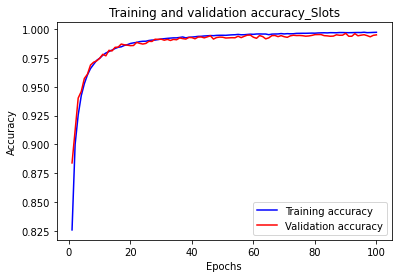

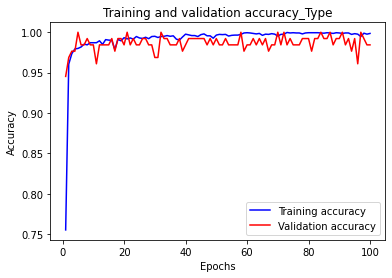

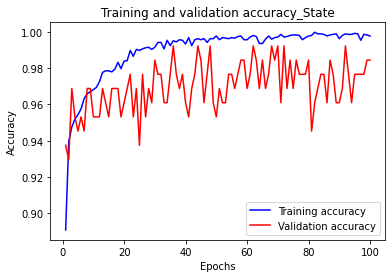

In [ ]:
import matplotlib.pyplot as plt

def plot_training_accuracy(history):

  acc_s = history.history['slot_output_sparse_categorical_accuracy']
  val_acc_s = history.history['val_slot_output_sparse_categorical_accuracy']

  acc_t = history.history['type_output_sparse_categorical_accuracy']
  val_acc_t = history.history['val_type_output_sparse_categorical_accuracy']

  acc_st = history.history['state_output_sparse_categorical_accuracy']
  val_acc_st = history.history['val_state_output_sparse_categorical_accuracy']

  epochs = range(1, len(acc_s) + 1)

  plt.plot(epochs, acc_s, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc_s, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy_Slots')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc_t, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc_t, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy_Type')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc_st, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc_st, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy_State')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
  
plot_training_accuracy(history)

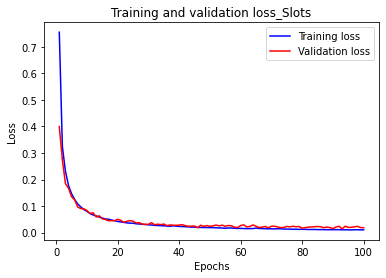

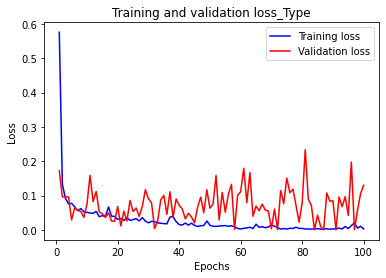

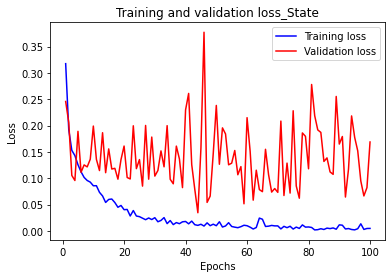

In [ ]:
import matplotlib.pyplot as plt

def plot_training_loss(history):

  loss_s = history.history['slot_output_loss']
  val_loss_s = history.history['val_slot_output_loss']

  loss_t = history.history['type_output_loss']
  val_loss_t = history.history['val_type_output_loss']

  loss_st = history.history['state_output_loss']
  val_loss_st = history.history['val_state_output_loss']

  epochs = range(1, len(loss_s) + 1)

  plt.plot(epochs, loss_s, 'b', label='Training loss')
  plt.plot(epochs, val_loss_s, 'r', label='Validation loss')
  plt.title('Training and validation loss_Slots')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss_t, 'b', label='Training loss')
  plt.plot(epochs, val_loss_t, 'r', label='Validation loss')
  plt.title('Training and validation loss_Type')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss_st, 'b', label='Training loss')
  plt.plot(epochs, val_loss_st, 'r', label='Validation loss')
  plt.title('Training and validation loss_State')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  
plot_training_loss(history)

## 7. Guardado de los pesos del modelo y los tokenizers

In [ ]:
model_name = 'vCPU_s2s_model_' + str(batch_size) + 'bs' + '128ld' + str(epochs) + 'epo' + str(word_emb_dim) + 'word_emb' + str(slot_emb_dim) + 'slot_emb_2021.h5'
msw = model.save_weights(model_name)

In [ ]:
# Save ModelFormat
#model_name = 'vCPU_s2s_model_' + str(batch_size) + 'bs' + '128ld' + str(epochs) + 'epo' + str(word_emb_dim) + 'word_emb' + str(slot_emb_dim) + 'slot_emb_2021'
#model.save(model_name)

In [ ]:
with open('/gdrive/My Drive/PEPS/' + model_name, 'wb') as wt: 
  pickle.dump(msw, wt, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
'''
with open('/gdrive/My Drive/PEPS/word_tokenizer', 'wb') as w_tok:
  pickle.dump(word_tokenizer, w_tok, protocol=pickle.HIGHEST_PROTOCOL)

with open('/gdrive/My Drive/PEPS/slot_tokenizer', 'wb') as s_tok:
  pickle.dump(slot_tokenizer, s_tok, protocol=pickle.HIGHEST_PROTOCOL)

with open('/gdrive/My Drive/PEPS/type_tokenizer', 'wb') as t_tok:
  pickle.dump(type_tokenizer, t_tok, protocol=pickle.HIGHEST_PROTOCOL)

with open('/gdrive/My Drive/PEPS/state_tokenizer', 'wb') as st_tok:
  pickle.dump(state_tokenizer, st_tok, protocol=pickle.HIGHEST_PROTOCOL)

# drive.flush_and_unmount()
# print('All changes made in this colab session should now be visible in Drive.')
'''

"\nwith open('/gdrive/My Drive/PEPS/word_tokenizer', 'wb') as w_tok:\n  pickle.dump(word_tokenizer, w_tok, protocol=pickle.HIGHEST_PROTOCOL)\n\nwith open('/gdrive/My Drive/PEPS/slot_tokenizer', 'wb') as s_tok:\n  pickle.dump(slot_tokenizer, s_tok, protocol=pickle.HIGHEST_PROTOCOL)\n\nwith open('/gdrive/My Drive/PEPS/type_tokenizer', 'wb') as t_tok:\n  pickle.dump(type_tokenizer, t_tok, protocol=pickle.HIGHEST_PROTOCOL)\n\nwith open('/gdrive/My Drive/PEPS/state_tokenizer', 'wb') as st_tok:\n  pickle.dump(state_tokenizer, st_tok, protocol=pickle.HIGHEST_PROTOCOL)\n\n# drive.flush_and_unmount()\n# print('All changes made in this colab session should now be visible in Drive.')\n"

PENDIENTES:

1) Prueba de modelos (cambiar los hiperparámetros)
* word embeddings: 128, 150, 200, 256 (250),..., 300, ..., 500
* slot embeddings: 6,..., 23 
* mantener epocas 20, 30, 50
* BATCH SIZE 16, 32, 64
* laten dim 128, 256, 200,..., 1024
* mantener pesos de pérdidas

2) Crear la función de pérdida ponderada

3) Entrenamiento final->guardamos pesos

In [ ]:
import re

fecha = '3 de abril de 2019'

año_actual = re.findall(r'\s\d{4}', fecha)

print(año_actual)

fecha_temp1 = '3 de abril del año en curso'
fecha_temp2 = '3 de abril del presente año'

replace1 = re.compile(r'( año en curso)|( presente año)')
text = re.sub(replace1, año_actual[0], fecha_temp2)

print(text)

[' 2019']
3 de abril del 2019
